<a href="https://colab.research.google.com/github/fadh1l/heart-pred-sys/blob/main/headpredDLModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from IPython.display import clear_output

In [49]:
data = pd.read_csv('heart.csv')

In [50]:
cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope' ]
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
target=["HeartDisease"]

In [51]:
train, test = train_test_split(data, stratify=data["HeartDisease"], test_size=0.2, random_state=42)

# LightGBM

In [52]:
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder

# LightGBM needs categorical columns encoded as integers
train_enc = train.copy()
test_enc = test.copy()
for col in cat_cols:
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", encoded_missing_value=np.nan, unknown_value=np.nan)
    train_enc[col] = enc.fit_transform(train_enc[col].values.reshape(-1,1))
    test_enc[col] = enc.transform(test_enc[col].values.reshape(-1,1))

In [53]:
clf = LGBMClassifier(random_state=42)
clf.fit(train_enc.drop(columns=target[0]), train_enc[target], categorical_feature=cat_cols)
test_pred = clf.predict(test_enc.drop(columns=target[0]))
test_pred_proba = clf.predict_proba(test_enc.drop(columns=target[0]))

acc = accuracy_score(test[target[0]].values, test_pred)
loss = log_loss(test[target[0]].values, test_pred_proba)
clear_output()

In [ ]:
print(f"Acc: {acc} | LogLoss: {loss}")

Acc: 0.8641304347826086 | LogLoss: 0.3897847590289178


In [55]:
validLossAcc = {}

In [63]:
validLossAcc.update({'LGBM':[{'test_loss': loss, 'test_accuracy': acc}]})

# PyTorch Tabular

In [ ]:
!pip install pytorch_tabular

In [ ]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import (
    CategoryEmbeddingModelConfig,
    FTTransformerConfig,
    TabNetModelConfig,
    GatedAdditiveTreeEnsembleConfig,
    TabTransformerConfig,
    AutoIntConfig
)
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig

## Common Configs    

These are common configs which can be reused. Since the datamodule is very quick, we can just stick with the high-level API

In [ ]:
data_config = DataConfig(
    target=target, #target should always be a list.
    continuous_cols=num_cols,
    categorical_cols=cat_cols,
)

trainer_config = TrainerConfig(
#     auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=256,
    max_epochs=500,
    early_stopping="valid_loss", # Monitor valid_loss for early stopping
    early_stopping_mode = "min", # Set the mode as min because for val_loss, lower is better
    early_stopping_patience=5, # No. of epochs of degradation training will wait before terminating
    checkpoints="valid_loss", # Save best checkpoint monitoring val_loss
    load_best=True, # After training, load the best checkpoint
)

optimizer_config = OptimizerConfig()

head_config = LinearHeadConfig(
    layers="", # No additional layer in head, just a mapping layer to output_dim
    dropout=0.1,
    initialization="kaiming"
).__dict__ # Convert to dict to pass to the model config (OmegaConf doesn't accept objects)

## CategoryEmbedding

In [84]:
model_config = CategoryEmbeddingModelConfig(
    task="classification",
    layers="64-32",  # Number of nodes in each layer
    activation="ReLU", # Activation between each layers
    learning_rate = 1e-2,
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train)
clear_output()

In [85]:
ce = tabular_model.evaluate(test)
validLossAcc.update({'CategoryEmbedding':ce})

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning:

You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing 
`Trainer(logger=ALogger(...))`

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning:

You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing
`Trainer(logger=ALogger(...))`

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │           0.875           │
│         test_loss         │    0.4109295606613159     │
└───────────────────────────┴───────────────────────────┘

## GATE (Full)    

[GATE](https://arxiv.org/pdf/2207.08548.pdf) proposes two configuration, a Full (larger) model and a lite (smaller) model.

In [106]:
model_config = GatedAdditiveTreeEnsembleConfig(
    task="classification",
    learning_rate = 1e-2,
    head = "LinearHead",
    head_config = head_config,
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train)
clear_output()

In [107]:
tabular_model.evaluate(test)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning:

You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing 
`Trainer(logger=ALogger(...))`

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning:

You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing
`Trainer(logger=ALogger(...))`

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8804348111152649     │
│         test_loss         │    0.3243118226528168     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3243118226528168, 'test_accuracy': 0.8804348111152649}]

## GATE (Lite)

In [ ]:
model_config = GatedAdditiveTreeEnsembleConfig(
    task="classification",
    learning_rate = 1e-3,
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
    gflu_stages=4,
    num_trees=30,
    tree_depth=5,
    chain_trees=False
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train)
clear_output()

In [ ]:
tabular_model.evaluate(test)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning: You called 
`self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing 
`Trainer(logger=ALogger(...))`
  rank_zero_warn(

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning: You called 
`self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing 
`Trainer(logger=ALogger(...))`
  rank_zero_warn(

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │           0.875           │
│         test_loss         │    0.32819992303848267    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.32819992303848267, 'test_accuracy': 0.875}]

## FT Transformer

[Paper](https://arxiv.org/abs/2106.11959)

In [104]:
model_config = FTTransformerConfig(
    task="classification",
    learning_rate = 1e-4,
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train)
clear_output()

In [105]:
ft = tabular_model.evaluate(test)
validLossAcc.update({'FTTransformer':ft})

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning:

You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing 
`Trainer(logger=ALogger(...))`

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning:

You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing
`Trainer(logger=ALogger(...))`

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.885869562625885     │
│         test_loss         │    0.3376290202140808     │
└───────────────────────────┴───────────────────────────┘

## TabTransformer    

[Paper](https://arxiv.org/abs/2012.06678)

In [80]:
model_config = TabTransformerConfig(
    task="classification",
    learning_rate = 1e-3,
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train)
clear_output()

In [81]:
tt = tabular_model.evaluate(test)
validLossAcc.update({'TabTransformer':tt})

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning:

You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing 
`Trainer(logger=ALogger(...))`

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning:

You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing
`Trainer(logger=ALogger(...))`

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.83152174949646      │
│         test_loss         │    0.37882572412490845    │
└───────────────────────────┴───────────────────────────┘

## AutoInt    

[Paper](https://arxiv.org/abs/1810.11921)

In [ ]:
model_config = AutoIntConfig(
    task="classification",
    learning_rate = 1e-3,
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train)
clear_output()

2023-10-08 21:04:32,591 - {pytorch_tabular.tabular_model:105} - INFO - Experiment Tracking is turned off
INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Global seed set to 42
2023-10-08 21:04:32,640 - {pytorch_tabular.tabular_model:473} - INFO - Preparing the DataLoaders
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
2023-10-08 21:04:32,645 - {pytorch_tabular.tabular_datamodule:290} - INFO - Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
2023-10-08 21:04:32,688 - {pytorch_tabular.tabular_model:521} - INFO - Preparing the Model: AutoIntModel
INFO:pytorch_tabular.tabular_model:Preparing the Model: AutoIntModel
/usr/local/lib/python3.10/dist-packages/pytorch_tabular/models/base_model.py:140: UserWarning: Wandb is not installed. Please install wandb to log logits. You can install wandb using pip install wandb or install PyTorch

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ AutoIntBackbone  │ 13.8 K │
│ 1 │ _embedding_layer │ Embedding2dLayer │    608 │
│ 2 │ _head            │ LinearHead       │    706 │
│ 3 │ loss             │ CrossEntropyLoss │      0 │
└───┴──────────────────┴──────────────────┴────────┘

Trainable params: 15.1 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 15.1 K                                                                                               
Total estimated model params size (MB): 0

Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning: You called 
`self.log('valid_loss', ..., logger=True)` but have no logger configured. You can enable one by doing 
`Trainer(logger=ALogger(...))`
  rank_zero_warn(

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning: You called 
`self.log('valid_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing 
`Trainer(logger=ALogger(...))`
  rank_zero_warn(

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning: You called 
`self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing 
`Trainer(logger=ALogger(...))`
  rank_zero_warn(

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning: You called 
`self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing 
`Trainer(logger=ALogger(...))`
  rank_zero_warn(

In [ ]:
tabular_model.evaluate(test)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning: You called 
`self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing 
`Trainer(logger=ALogger(...))`
  rank_zero_warn(

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning: You called 
`self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing 
`Trainer(logger=ALogger(...))`
  rank_zero_warn(

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9021739363670349     │
│         test_loss         │    0.31201061606407166    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.31201061606407166, 'test_accuracy': 0.9021739363670349}]

## TabNet    

[Paper](https://arxiv.org/abs/1908.07442)

In [ ]:
model_config = TabNetModelConfig(
    task="classification",
    learning_rate = 1e-3,
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train)
clear_output()

In [61]:
tn = tabular_model.evaluate(test)
validLossAcc.update({'CategoryEmbedding':tn})

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning: You called 
`self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing 
`Trainer(logger=ALogger(...))`
  rank_zero_warn(

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:493: UserWarning: You called 
`self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing 
`Trainer(logger=ALogger(...))`
  rank_zero_warn(

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.864130437374115     │
│         test_loss         │    0.3877244293689728     │
└───────────────────────────┴───────────────────────────┘

In [108]:
print(*[i for i in list(validLossAcc.items())],sep='\n')

('LGBM', [{'test_loss': 0.3897847590289178, 'test_accuracy': 0.8641304347826086}])
('CategoryEmbedding', [{'test_loss': 0.4109295606613159, 'test_accuracy': 0.875}])
('FTTransformer', [{'test_loss': 0.3376290202140808, 'test_accuracy': 0.885869562625885}])
('TabTransformer', [{'test_loss': 0.37882572412490845, 'test_accuracy': 0.83152174949646}])


In [74]:
validLossAcc.keys()

dict_keys(['LGBM', 'CategoryEmbedding', 'FTTransformer', 'TabTransformer'])

IndexError: ignored

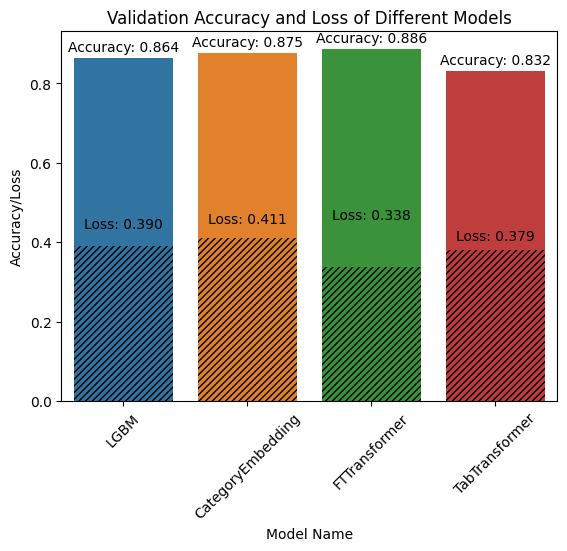

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a list of model names, validation accuracies, and validation losses
model_names = list(validLossAcc.keys())
validation_accuracies = [validLossAcc[model_name][0]['test_accuracy'] for model_name in model_names]
validation_losses = [validLossAcc[model_name][0]['test_loss'] for model_name in model_names]

# Create a bar chart of the validation accuracies and losses
fig, ax = plt.subplots()
sns.barplot(
    x=model_names, y=validation_accuracies, label="Accuracy", ax=ax
)
sns.barplot(
    x=model_names,
    y=validation_losses,
    label="Loss",
    alpha=0.85,
    hatch="/////",
    ax=ax,
)

# Rotate the x-axis labels to prevent overlapping
ax.set_xticklabels(model_names, rotation=45)

# Set the title and labels of the plot
ax.set_title("Validation Accuracy and Loss of Different Models")
ax.set_xlabel("Model Name")
ax.set_ylabel("Accuracy/Loss")

# Add the values of loss and accuracy above the graphs
for i, rect in enumerate(ax.patches):
    height = rect.get_height()
    accuracy = validation_accuracies[i]
    loss = validation_losses[i]

    # Calculate the y-position for the loss text
    loss_y_pos = height - 0.4

    ax.text(
        rect.get_x() + rect.get_width() / 2,
        loss_y_pos,
        f"Loss: {loss:.3f}",
        ha="center",
        va="top",
    )

    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + 0.01,
        f"Accuracy: {accuracy:.3f}",
        ha="center",
        va="bottom",
    )


# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()
